# Segmentation with OTSU
## exhaustive search with iterative algorithm
## evaluating objective function on-demand vs pre-calculated


# estrutura

## leitor e conversor de imagens coloridas a preto-branco

## processador de imagem escolhida para teste:

## input

### 0. imagem de teste
### 1. número de clusters variavel de 2 a Kmax
### 2. número de repeticoes do experimento

## output 
### 1. tempo medio de inicializacao e desvio padrão
### 2. tempo medio do processo iterativo e desvio padrão
### 3. limiares ótimos
### 4. plot das imagens segmentadas (mascaras) + histograma com posição dos limiares


In [23]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

import numpy as np
from numpy import mean
from numpy import isnan
from numpy import asarray

import os
import shutil, glob, os.path

from random import shuffle

import skimage
from skimage import data, io, color, exposure, feature

from skimage.filters import threshold_otsu 
from skimage.feature import canny # edge extraction

from tqdm import tqdm

import math

import time

from random import randint


In [24]:
INPUT_PATH = 'C:/Users/evelyn.ferreira/Desktop/dataset'

Files=os.listdir(INPUT_PATH)

nImg=len(Files)

print("number of images: ",nImg)

number of images:  4


In [25]:
# preprocessamento das imagens do arquivo -> retorna uma imagem 1D em grayscale normalizada entre 0:255

def image_loader(path,toplt,topltgray):
    Image = io.imread(path) # load image in np.array
    if toplt:
        fig2, ax2 = plt.subplots(1,2, figsize=(12, 5.5))
        ax2[0].imshow(Image)
        ax2[1].hist(Image.ravel(), bins = 64, color = 'orange', alpha = 0.5)
        ax2[1].hist(Image[:, :, 0].ravel(), bins = 64, color = 'red', alpha = 0.5)
        ax2[1].hist(Image[:, :, 1].ravel(), bins = 64, color = 'Green', alpha = 0.5)
        ax2[1].hist(Image[:, :, 2].ravel(), bins = 64, color = 'Blue', alpha = 0.5)
        ax2[1].set_xlim(0, 255)
        ax2[1].set_xlabel('Intensity Value')
        ax2[1].set_ylabel('Count')
        ax2[1].legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
        plt.show()
    
    if Image.shape[2]>=3: # if RGB or similar
        gray=0
    else: # grayscale input
        gray=1
        
    x=Image.shape[0]
    y=Image.shape[1]
    
    image=[] # vetor 1D de pixels monocromáticos
    
    for i in range(x):
        for j in range(y):
            if gray==0:
                image.append(int(0.2989*Image[i][j][0]+0.5870*Image[i][j][1]+0.1140*Image[i][j][2])) # color to gray scale
            else: # gray inpt image
                image.append(int(Image[i][j]))

 # normalization of grayscale to 0:255 interval for each image (MinMaxScaler)
    image=np.array(image)
    Mx=np.max(image)
    mx=np.min(image)
    image=(255*(image-mx)/(Mx-mx)).astype(int)  
    
    if topltgray:
        gimage=image.reshape(x,y)
        fig2, ax2 = plt.subplots(1,2, figsize=(12, 5.5))
        plt.style.use('grayscale')
        ax2[0].imshow(gimage)
        ax2[1].hist(gimage.ravel(), bins = 64, color = 'orange',alpha = 0.5)
        ax2[1].set_xlim(0, 255)
        ax2[1].set_xlabel('Intensity Value')
        ax2[1].set_ylabel('Count')
        ax2[1].legend(['Total'])
        plt.show()
        
    return Image.shape[0], Image.shape[1], image, Image

  0%|          | 0/4 [00:00<?, ?it/s]

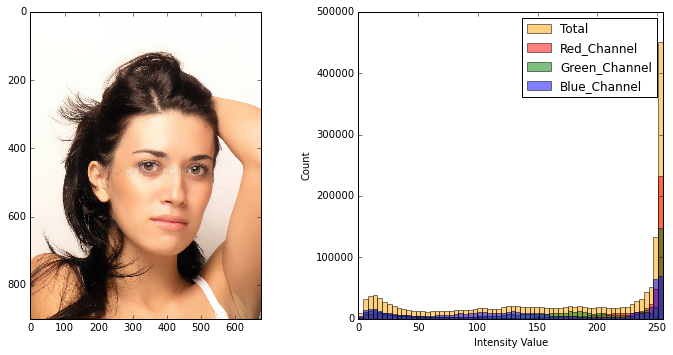

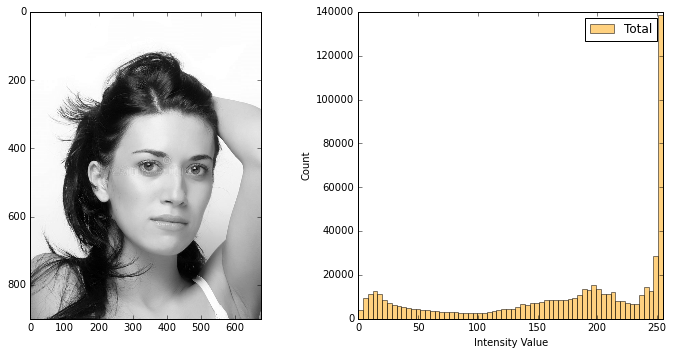

 25%|██▌       | 1/4 [00:06<00:19,  6.59s/it]

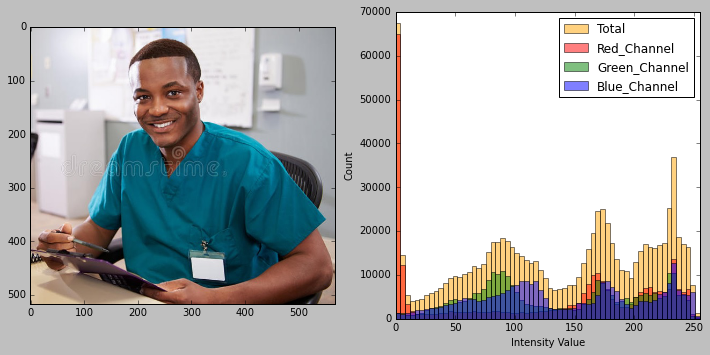

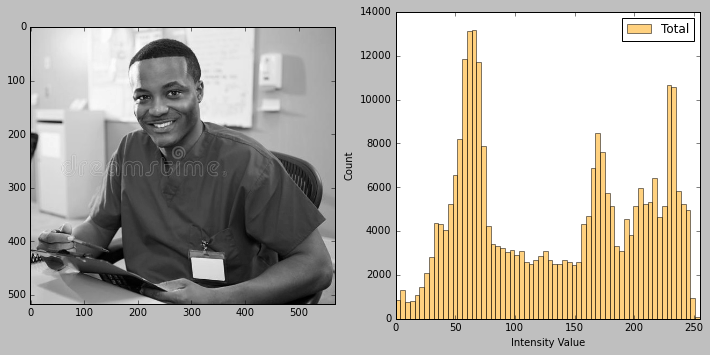

 50%|█████     | 2/4 [00:10<00:11,  5.73s/it]

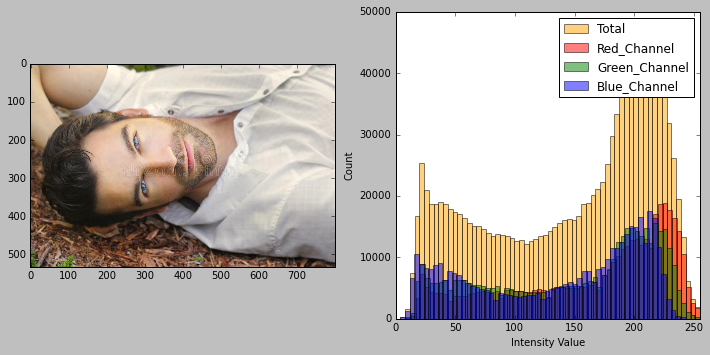

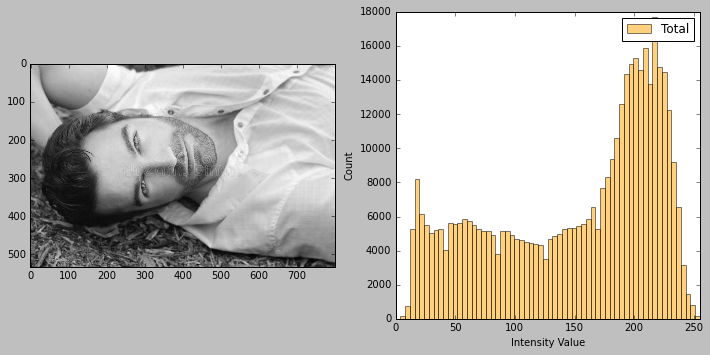

 75%|███████▌  | 3/4 [00:15<00:05,  5.60s/it]

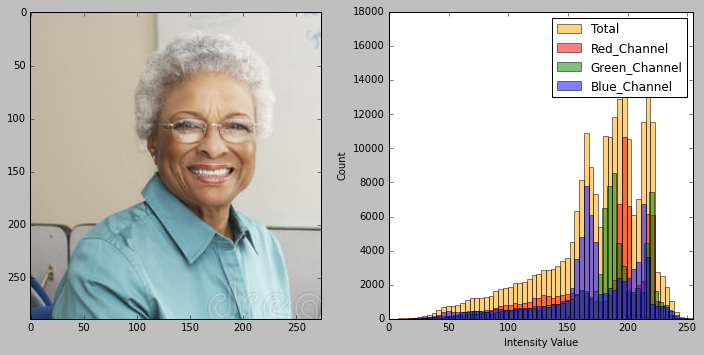

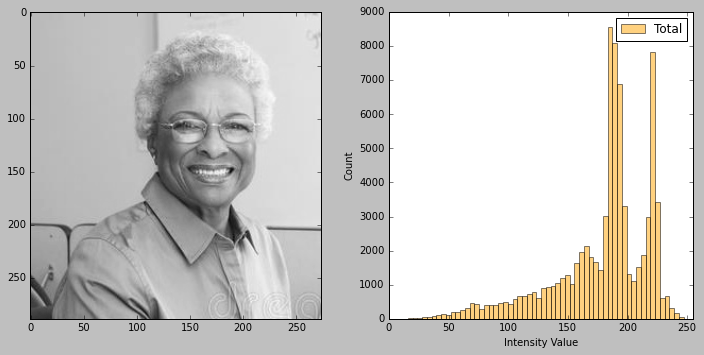

100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


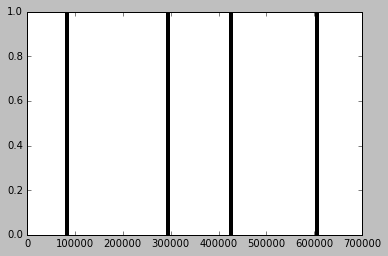

menor imagem  79186  maior imagem  607500


In [26]:
# load and preprocess image data set + MAPEA O INTERVALO DE VARIAÇÃO DO TAMANHO n DAS IMAGENS NA PASTA 

X=[]
O=[]
ResX=[]
ResY=[]
n=[]

nImg=4

for file in tqdm(Files[:nImg]): # tqdm(Files[:nImg]): #
    
    path=os.path.join(INPUT_PATH, file)
    X.append([])
    O.append([])
    
    RX, RY, Img, OrigImg = image_loader(path,True,True) # returns a grayscale image of the same size. bool prm: plot RGB & plot grayscale
    
    n.append(Img.shape[0])
    
#    print("n = ",n[-1])
    
    ResX.append(RX)
    ResY.append(RY)
    X[-1].append(Img)
    O[-1].append(OrigImg)

# PLOTA HISTOGRAMA DE TAMANHOS
plt.hist(n,bins=100)
plt.show()
print("menor imagem ",np.min(n)," maior imagem ",np.max(n))

In [27]:
# Y contains the images to process

Y=[]
oI=[]

print("numero de imagens: ",nImg)
for i in range(nImg):
    #debb
    #print('sample ', i)    
    Y.append([])
    oI.append([])
    Y[-1]=X[i][0]
    oI[-1]=O[i][0]
    #debb
    #print(np.min(Y[-1]),":",np.max(Y[-1]))

O=[]
#debb
#print(Y)

numero de imagens:  4


In [28]:
def histo(img,M): # input img 1D
    
    p=np.zeros((M),dtype=float)
    n=len(img)
    
    for i in range(n):
        p[img[i]]+=1
        
    return np.max(p), p/n

In [29]:
def BuildOTSUTables2(frq,L):  # L =256
    
    H=np.zeros((L,L),dtype=float)
    
    C=frq[0]
    for i in range(1,L):
        C+=(i+1)*frq[i]

    for i in range(L): # linha
        p = frq[i]
        s = (i+1)*frq[i]
        if p>0: # diagonal elements
            H[i,i]=p*(int(s/p)-C)**2
        for j in range(i+1,L): # off-diagonal elements by recorrencia
            p+=frq[j]
            s+=(j+1)*frq[j]
            if p>0:
                H[i,j]=p*(int(s/p)-C)**2
                
    return H

In [30]:
def FUNOBJ_PC(T,K,H,L): # função objetivo OTSU original
    
    t=[-1]+list(np.array(T)-1)+[L-1]
    
    Q=0
    for i in range(K):
        Q+=H[t[i]+1,t[i+1]]
           
    return Q


In [31]:
def segment(K,L,img):
         
    if K<2 or K>6:
        print("K fora do intervalo 2-4")
        return []
    else:  
        
        bg=time.time()
        Qmax=0
        fMax=[]

        # calcula histograma

        hist_max, p = histo(img,L)
        
        H=BuildOTSUTables2(p,L)
    
        f=[]
        for i in range(K-1):
            f.append(i)
 
        init_time=time.time()-bg   
        
        bg=time.time()
        itera=0
        a=L-K+2
        
        if K==2:
            for f[0] in range(0,a):
                itera+=1
                Q=FUNOBJ_PC(f,K,H,L)
#                 print('calculo com thresholds',f,Q)
                if Q>Qmax:
                    Qmax=Q
                    fMax=f.copy()
                    
        elif K==3:
            b=a+1 #
            for f[0] in range(0,a):
                e=f[0]+1
                for f[1] in range(e,b): 
                    itera+=1
                    Q=FUNOBJ_PC(f,K,H,L)
#                     print('calculo com thresholds',f,Q)
                    if Q>Qmax:
                        Qmax=Q
                        fMax=f.copy()

        elif K==4:
            b=a+1 # M-(K-1)+2
            d=b+1 # M-(K-2)+2
            for f[0] in range(0,a):
                e=f[0]+1
                for f[1] in range(e,b): 
                    g=f[1]+1
                    for f[2] in range(g,d):
                        itera+=1
                        Q=FUNOBJ_PC(f,K,H,L)
                        if Q>Qmax:
                            Qmax=Q
                            fMax=f.copy()

        elif K==5:
            b=a+1 # M-(K-1)+2
            d=b+1 # M-(K-2)+2
            h=d+1 # M-(K-3)+2
            for f[0] in range(0,a):
                e=f[0]+1
                for f[1] in range(e,b): 
                    g=f[1]+1
                    for f[2] in range(g,d):
                        l=f[2]+1
                        for f[3] in range(l,h):
                            itera+=1
                            Q=FUNOBJ_PC(f,K,H,L)
                            if Q>Qmax:
                                Qmax=Q
                                fMax=f.copy()

        elif K==6:
            b=a+1 # M-(K-1)+2
            d=b+1 # M-(K-2)+2
            h=d+1 # M-(K-3)+2
            q=h+1 # M-(K-4)+2
            for f[0] in range(0,a):
                e=f[0]+1
                for f[1] in range(e,b): 
                    g=f[1]+1
                    for f[2] in range(g,d):
                        l=f[2]+1
                        for f[3] in range(l,h):
                            s=f[3]+1
                            for f[4] in range(s,q):
                                itera+=1
                                Q=FUNOBJ_PC(f,K,H,L)
                                if Q>Qmax:
                                    Qmax=Q
                                    fMax=f.copy()

        iter_time=(time.time()-bg)   
                            
    return init_time, iter_time, itera, fMax
                    

In [32]:
test=1 # SELECIONA UMA IMAGEM DADA PARA FAZER O TESTE DOS CODIGOS FONTE 

my_color = []
my_color.append('#%06X' % 0)
my_color.append('#%06X' % 0xFFFFFF)
for i in range(20):
    my_color.append('#%06X' % randint(0, 0xFFFFFF))

In [33]:
import csv

In [34]:
def registerTimes(filename: str, init_times: list, iter_times: list, n_iters: list, img_size: int, n_clusters: int, n_rounds:int) -> None:
    
    csv_filename: str = filename + '.csv'
    with open(csv_filename,'a+',encoding='UTF8') as handler:
        writer = csv.writer(handler)
        writer.writerow(['N','K','Initilization','Iteration','Repetitions'])
        for round in range(n_rounds):
            writer.writerow([img_size,n_clusters,init_times[round],iter_times[round],n_iters[round]])
        writer.writerow(['Means',' ',np.mean(init_times),np.mean(iter_times),np.mean(n_iters)])
        writer.writerow(['Stds',' ',np.std(init_times),np.std(iter_times),np.std(n_iters)])
        writer.writerow(['Stabilished',' ',(np.std(init_times)/np.mean(init_times)),(np.std(iter_times)/np.mean(iter_times)),' '])
        writer.writerow([' ',' ',' ',' ',' '])

## FUNÇÃO ITERATIVA

n   K   inTime (Std) itTime (Std) best_thresholds
607500 2 0.5236983299255371 ( 0.037976851712435124 ) 0.0016012191772460938 ( 0.0004902245804275277 ) [142]


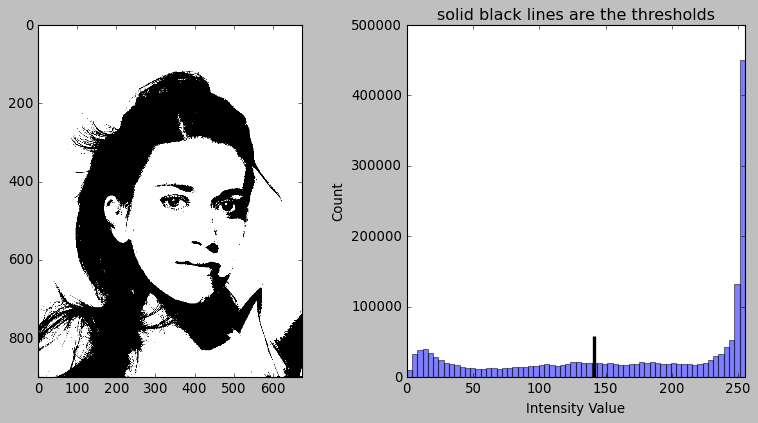

607500 3 0.49399871826171876 ( 0.006434940079624148 ) 0.20120062828063964 ( 0.0019549481914596526 ) [101, 211]


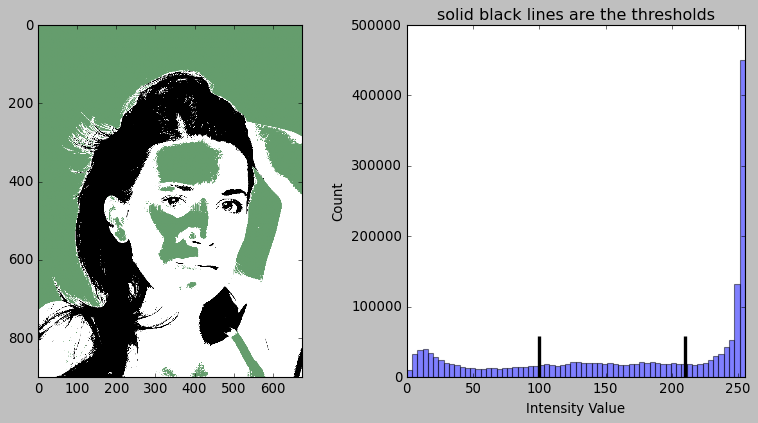

607500 4 0.5283363819122314 ( 0.05876277128498503 ) 21.130002975463867 ( 1.690674659233521 ) [81, 160, 220]


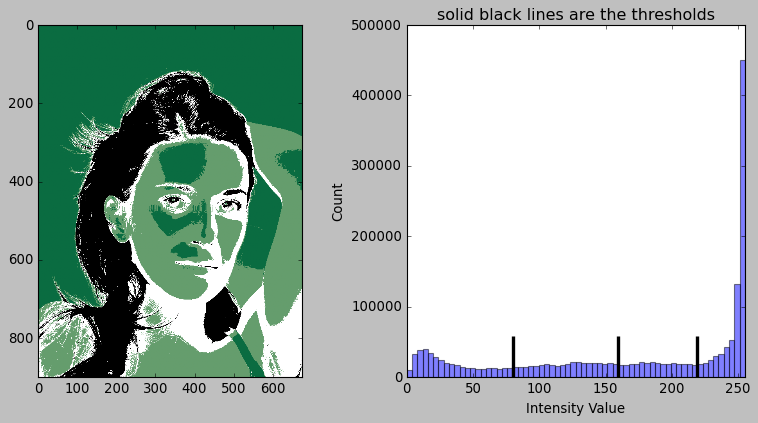

607500 5 0.7011999368667603 ( 0.39644261366916844 ) 1982.0975712299346 ( 766.8547589618325 ) [64, 121, 175, 220]


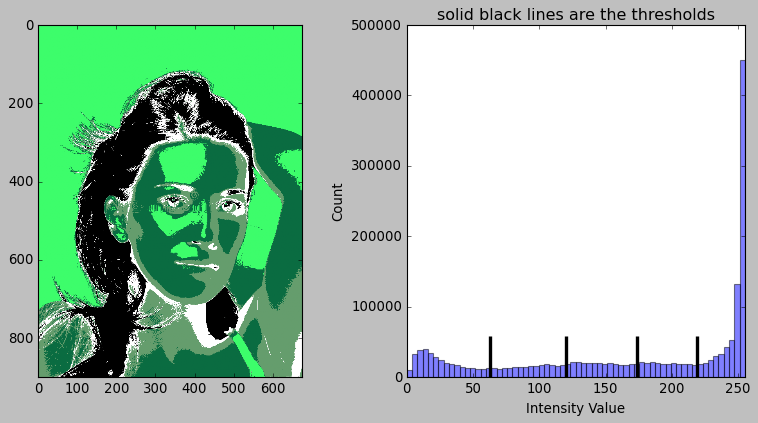

n   K   inTime (Std) itTime (Std) best_thresholds
293656 2 0.7101997375488281 ( 0.010721942259418955 ) 0.0034000158309936525 ( 0.0004894068651212667 ) [136]


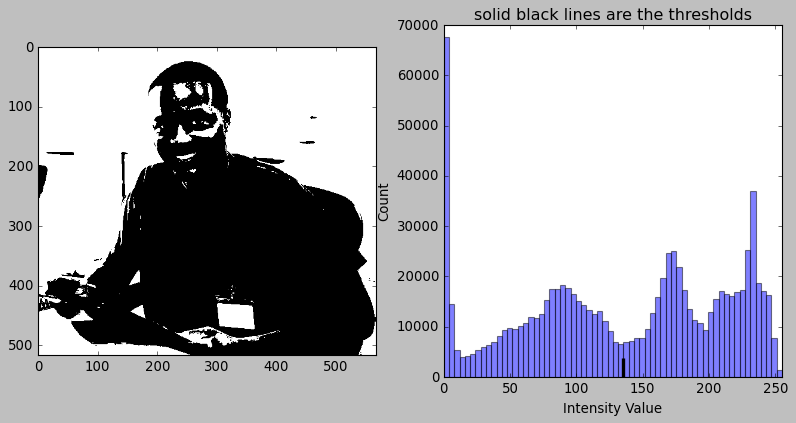

293656 3 0.7187995910644531 ( 0.009217624208855012 ) 0.5371002435684205 ( 0.005337768395671435 ) [111, 183]


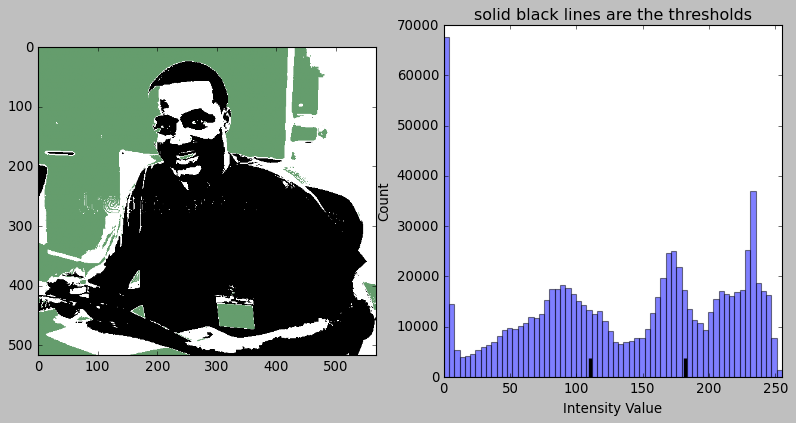

293656 4 0.731899642944336 ( 0.0393132329731169 ) 51.6465001821518 ( 0.7926510715832433 ) [78, 142, 195]


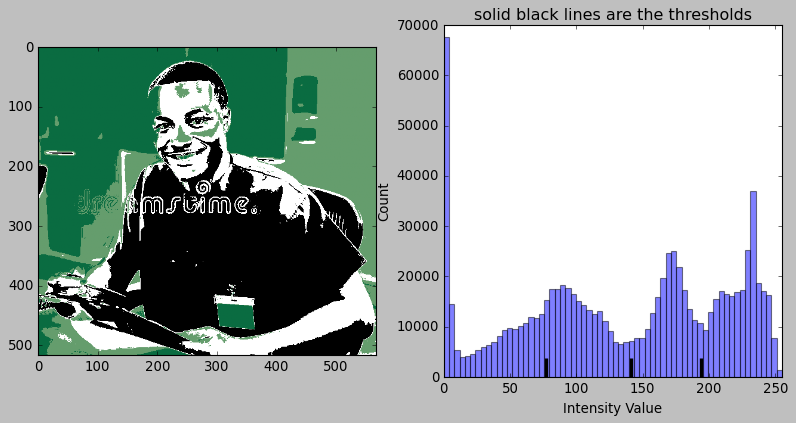

293656 5 0.6149033784866333 ( 0.1309720674397034 ) 2870.9528611660003 ( 644.111919109369 ) [53, 95, 145, 198]


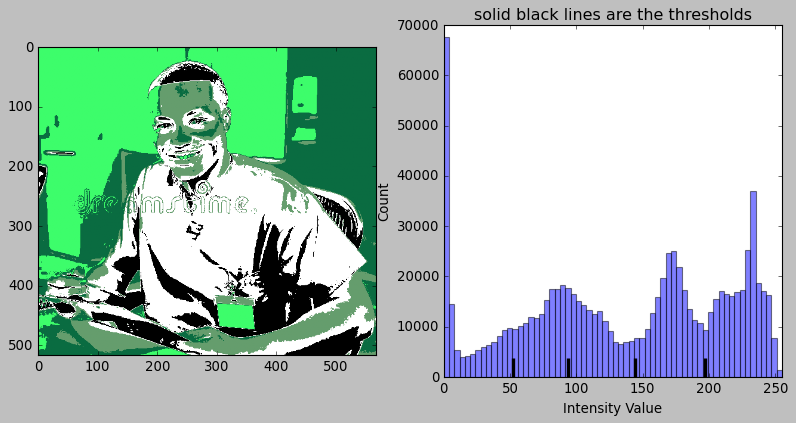

n   K   inTime (Std) itTime (Std) best_thresholds
426400 2 0.4436986207962036 ( 0.012082673550567519 ) 0.0018010616302490234 ( 0.00040015367457980254 ) [138]


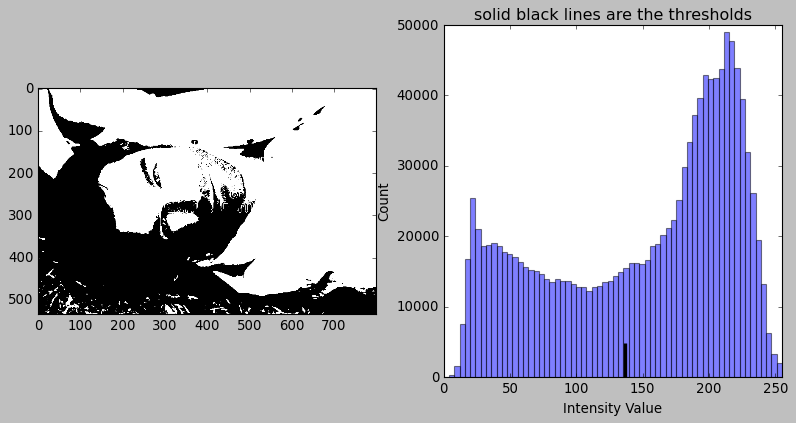

426400 3 0.4720932960510254 ( 0.04669758291983002 ) 0.2700063705444336 ( 0.04050827185212805 ) [99, 174]


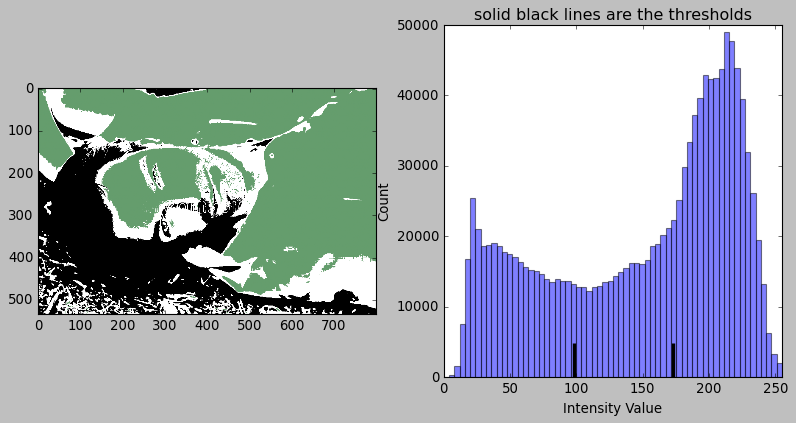

426400 4 0.5354687213897705 ( 0.11823654035962113 ) 27.504892444610597 ( 2.411293932825047 ) [71, 134, 193]


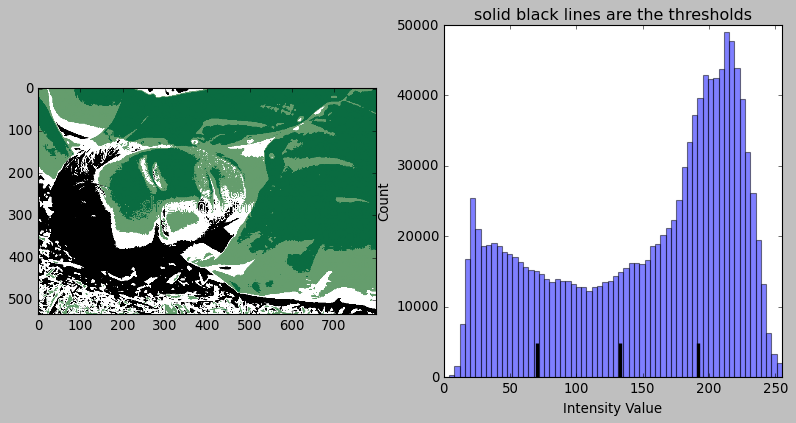

426400 5 0.7655994176864624 ( 0.17571226360525966 ) 2890.6685191869738 ( 699.0313211047076 ) [59, 116, 160, 201]


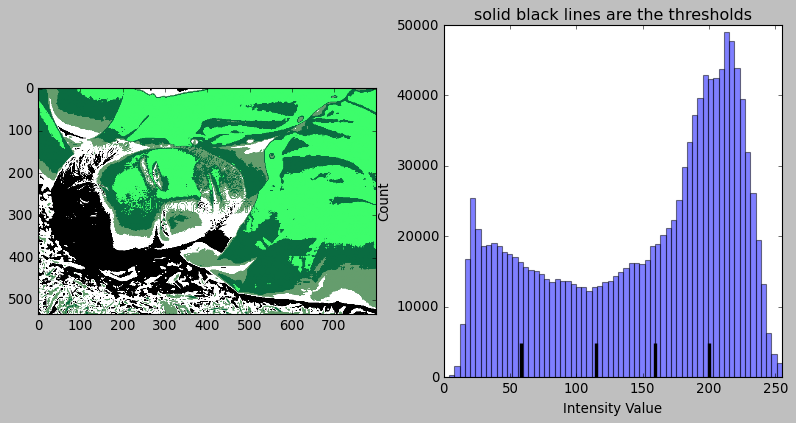

n   K   inTime (Std) itTime (Std) best_thresholds
79186 2 0.14890213012695314 ( 0.004200099887157012 ) 0.0015944719314575195 ( 0.0004924379319490765 ) [152]


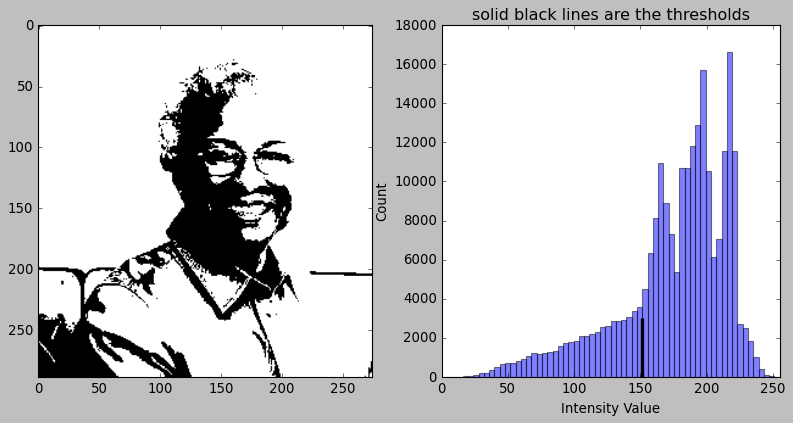

79186 3 0.15288965702056884 ( 0.010597376589841851 ) 0.2466104507446289 ( 0.024997281875750357 ) [146, 203]


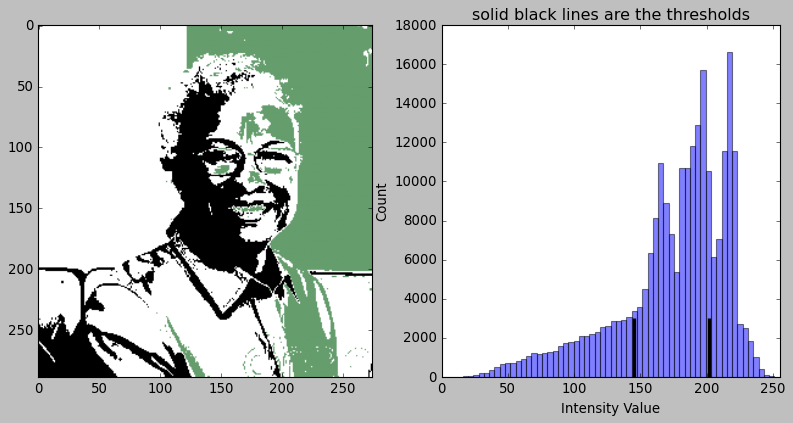

79186 4 0.1698146343231201 ( 0.0330713138232875 ) 25.951761627197264 ( 2.676120087436126 ) [116, 170, 203]


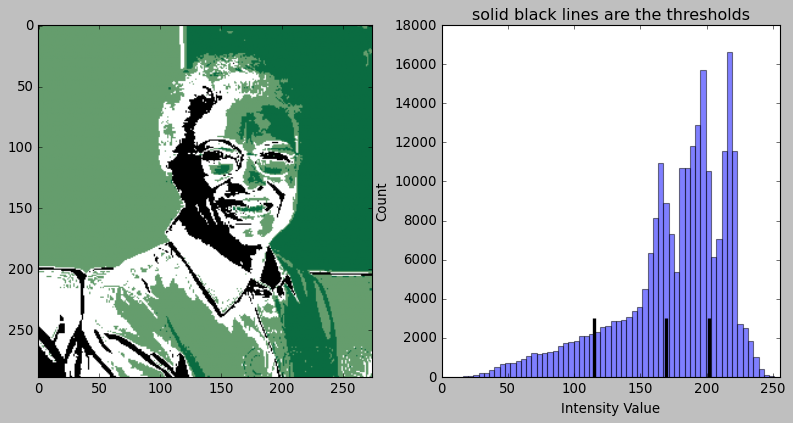

79186 5 0.17880408763885497 ( 0.0527805899197056 ) 1892.1322308301926 ( 302.87110324949754 ) [96, 138, 170, 203]


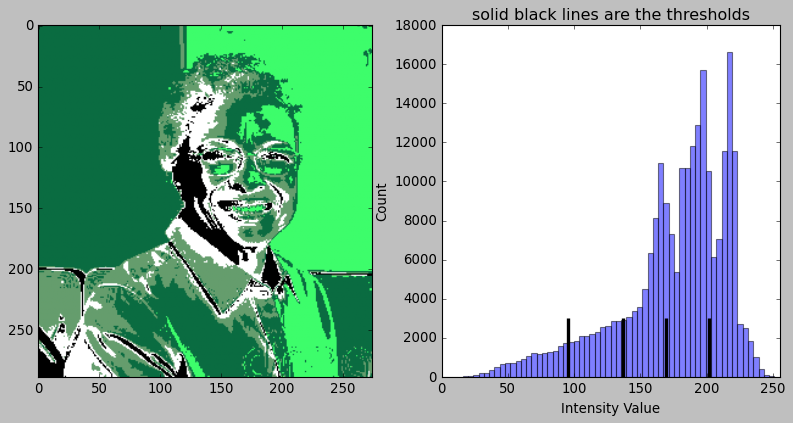

In [35]:
# PARAMETERS

plt.style.use('classic')

L=256 # numero de escalas de cinza

nexp=10 # repetições do experimento

Kmax=5

dataset = []  #identificador das imagens

# loop por imagens - test

for j in range(nImg):
    
    print("n   K   inTime (Std) itTime (Std) best_thresholds")
    x=ResX[j]
    y=ResY[j]
    N=x*y # tamanho da imagem
    dataset.insert(j, str(N))
    for K in range(2,Kmax+1):

        InTime=[]
        ItTime=[]
        IterTime =[]

        for i in range(nexp):

            inittime,itertime, iterations, thresholds = segment(K,L,Y[j])

            InTime.append(inittime)
            ItTime.append(itertime)
            IterTime.append(iterations)

        print(N,K,np.mean(InTime),'(',np.std(InTime),')',np.mean(ItTime),'(',np.std(ItTime),')',thresholds)
        
        registerTimes(filename=dataset[j],img_size=N,init_times=InTime,iter_times=ItTime,n_iters=IterTime,n_clusters=K,n_rounds=nexp)

        # fill image

        f=[-1]+list(np.array(thresholds)-1)+[L-1]

        # classificando pixels

        Mask=[]
        for i in range(N):
            for k in range(K):
                if Y[j][i]>f[k] and Y[j][i]<=f[k+1]:
                    Mask.append(colors.hex2color(my_color[k]))
                    break

         #PLOT 

        fig, ax = plt.subplots(1,2, figsize=(12, 5.5))
        ax[0].imshow(np.array(Mask).reshape(x,y,-1))
        ax[1].hist(oI[j].ravel(), bins = 64, color = 'blue',alpha = 0.5)
        ax[1].set_xlim(0, L-1)
        hist_max, p=histo(Y[j],L)
        ax[1].vlines(f[1:K],0,hist_max,linewidths=3,colors='black')
        ax[1].set_xlabel('Intensity Value')
        ax[1].set_ylabel('Count')
        ax[1].set_title('solid black lines are the thresholds')
        plt.show()
   
    